# **Definindo Funções, Bibliotecas e Inputs**

## *Bibliotecas*

In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from xgboost import XGBRegressor

import matplotlib.pyplot as plt
import seaborn as sns
import math

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## *Plots setup*

In [2]:
plt.style.use("seaborn-whitegrid")
plt.rc(
    "figure",
    autolayout=True,
    figsize=(11, 4),
    titlesize=18,
    titleweight='bold',
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'


def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax


def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("1Y") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    plt.show()
    return ax

/tmp/ipykernel_20/2294217787.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


## *Leitura dos dados*

Dataset disponível em https://www.kaggle.com/competitions/store-sales-time-series-forecasting

In [3]:
dtype = {'store_nbr': 'category','family': 'category','sales': 'float32','onpromotion': 'uint64'}
train = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/train.csv', dtype=dtype, parse_dates=['date'], infer_datetime_format=True)
train = train.set_index('date').to_period('D')

dtype = {'store_nbr': 'category','family': 'category','onpromotion': 'uint64'}
test = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/test.csv', dtype=dtype, parse_dates=['date'], infer_datetime_format=True)
test = test.set_index('date').to_period('D')

dtype = {'type': 'string','locale': 'category','locale_name': 'string','description': 'string', 'transferred' : 'bool'}
holidays = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv', dtype=dtype, parse_dates=['date'], infer_datetime_format=True)
holidays = holidays.set_index('date').to_period('D')

dtype = {'store_nbr': 'category','city': 'string','state': 'string','type': 'category', 'cluster' : 'uint64'}
stores = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/stores.csv', dtype=dtype)

sample = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv')

dtype = {'dcoilwtico': 'float32'}
oil = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/oil.csv', dtype=dtype, parse_dates=['date'], infer_datetime_format=True)
oil = oil.set_index('date').to_period('D')

# **Main Functions Decomposition**

## *Trend*

In [4]:
# mostra o gráfico da média móvel para a decisão do valor da ordem da tendência, se a equação que buscamos será de ordem 0, 1, 2, etc.
def Trend_evaluation(df_train,  window=365):
    moving_average = df_train['sales'].rolling(window=window, center=True, min_periods=window//2).mean()
    ax = df_train['sales'].plot(style=".", color="0.5")
    moving_average.plot(ax=ax, linewidth=3, title="Discovering trend order - 365-Day Moving Average")
    plt.show()

# treinamento do modelo para encontrar a tendência através da equação de ordem 'ord'
def Trend_train(df_train, df_test, model=LinearRegression(fit_intercept=False), ord=1, show=True):
    dp_trend = DeterministicProcess(index=df_train.index, constant=True, order=ord, drop=True)
    
    X_train = dp_trend.in_sample()
    y_train = df_train["sales"]
    model.fit(X_train, y_train)
    y_pred = pd.Series(model.predict(X_train), index=X_train.index)
    
    X_fore = dp_trend.out_of_sample(steps=len(df_test.index)+10)
    X_fore = X_fore.reindex(df_test.index) #eventualmente retirando os dados do natal
    y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

    # mostra o gráfico da predição do modelo
    if show:
        ax = df_train['sales'].plot(title="Trend Forecast", **plot_params)
        if 'sales' in df_test.columns:
            ax = df_test["sales"].plot(ax=ax, **plot_params)
        ax = y_pred.plot(ax=ax, linewidth=3, label="Fitted")
        ax = y_fore.plot(ax=ax, linewidth=3, label="Forecast", color="C3")
        ax.legend()
        plt.show()

    return y_fore

## *Seasonality*

In [5]:
# devolve duas tabela indexadas pela data de eventos importantes ('Event'/'Holiday') 
def Holidayzando(df_train, df_vali, national=True, reg_loc=False, sto_nbr='10'):
    global stores, holidays
    locations_to_filter = []
    
    # considera feriados regionais e locais de uma loja específica
    if reg_loc:
        loja = stores[stores['store_nbr'] == sto_nbr]
        city = loja['city'].values[0]
        state = loja['state'].values[0]
        locations_to_filter.append(city)
        locations_to_filter.append(state)

    # considera eventos e feriados nacionais do país
    if national:
        country = 'Ecuador'
        locations_to_filter.append(country)

    # eventos recorrentes do país, os demais não se repetem
    ev_recorrentes = ['Dia de la Madre', 'Black Friday', 'Cyber Monday']
    ev = holidays[holidays['type'] == 'Event']
    ev = ev[ev['description'].isin(ev_recorrentes)]
    ev['type'] = 'Holiday'

    feriados = pd.concat([holidays, ev]).sort_index()
    feriados = feriados[feriados['locale_name'].isin(locations_to_filter)]
    feriados = feriados[feriados['transferred'] == False]

    # renomeando feriados transferidos
    for i in range(len(feriados.index)):
        if feriados.iloc[i]['type'] == 'Transfer':
            feriados.loc[feriados.index[i], 'description'] = feriados.loc[feriados.index[i]]['description'].replace("Traslado ", "")
    
    feriados_train = feriados.query("type in ['Holiday', 'Transfer']").loc[df_train.index[0]:df_vali.index[-1], ['description']]
    feriados_vali = feriados.query("type in ['Holiday', 'Transfer']").loc[df_vali.index[0]:df_vali.index[-1], ['description']]
    
    return feriados_train, feriados_vali

In [6]:
# mostra o gráfico de vendas por dia da semana/ano e o periodograma
def Indicators_evaluation(df_train):
    X = df_train.copy()
    X["day"] = X.index.dayofweek
    X["week"] = X.index.week
    X["dayofyear"] = X.index.dayofyear
    X["year"] = X.index.year

    fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(11, 6))
    seasonal_plot(X, y="sales", period="week", freq="day", ax=ax0)
    seasonal_plot(X, y="sales", period="year", freq="dayofyear", ax=ax1)

    # mostra o gráfico para análise dos parâmetros do CalendarFourier
    plot_periodogram(df_train['sales'])

    
    
# plot do quão eficiente o modelo foi em retirar a sazonalidade
def Seasonality_efficiency(df_train, y_pred):
    y_deseason = df_train['sales'] - y_pred
    #fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))
    ax1 = plot_periodogram(df_train['sales'])
    ax1.set_title("Product Sales Frequency Components")
    ax2 = plot_periodogram(y_deseason)
    ax2.set_title("Deseasonalized")
    plt.show()
    
    
    
# treinamento do modelo para encontrar a sazonalidade+tendência através dos parâmetros da ordem de fourier e com feriados
def Seasonality_train_holi(df_train, df_test, ord=1, wee=True, A_ord=0, M_ord=0, W_ord=0, model=LinearRegression(fit_intercept=False), show=True):
    add = []
    # fourier anual
    if A_ord > 0:
        fourier1 = CalendarFourier(freq="A", order=A_ord)
        add.append(fourier1)
    # fourier mensal
    if M_ord > 0:
        fourier2 = CalendarFourier(freq="M", order=M_ord)
        add.append(fourier2)
    # fourier semanal
    if W_ord > 0:
        fourier3 = CalendarFourier(freq="W", order=W_ord)
        add.append(fourier3)

    dp_seasonal = DeterministicProcess(
        index=df_train.index,
        constant=True,
        order=ord,                   # trend
        seasonal=wee,                # weekly seasonality (indicators)
        additional_terms=add,        # A,M,W seasonality (fourier)
        drop=True,                   # drop terms to avoid collinearity
    )

    feriados_train, feriados_test = Holidayzando(df_train, df_test)
    feriados_train = feriados_train[~((feriados_train.index.month == 12) & (feriados_train.index.day == 25))]
    feriados_test = feriados_test[~((feriados_test.index.month == 12) & (feriados_test.index.day == 25))]
        
    X_feriados_train = pd.get_dummies(feriados_train)
    X_feriados_fore = pd.get_dummies(feriados_test)

    X_train = dp_seasonal.in_sample()
    X_train = pd.concat([X_train, df_train['dcoilwtico'], df_train['onpromotion']], axis=1)
    X_train = X_train.join(X_feriados_train, on='date').fillna(0.0)
    y_train = df_train['sales']
    model.fit(X_train, y_train)
    y_pred = pd.Series(model.predict(X_train), index=X_train.index)

    X_fore = dp_seasonal.out_of_sample(steps=len(df_test.index)+10)
    X_fore = pd.concat([X_fore, df_test['dcoilwtico'], df_test['onpromotion']], axis=1)
    X_fore = X_fore.reindex(df_test.index)
    
    X_fore = X_fore.join(X_feriados_train).fillna(0.0)
    for i in range(len(X_feriados_fore.index)):
        for j in X_feriados_fore.columns.tolist():
            if X_feriados_fore.iloc[i][j] == 1:
                X_fore.at[X_feriados_fore.index[i], j] = 1
    y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

    # mostra o gráfico da predição do modelo
    if show:
        ax = df_train['sales'].plot(title="Seasonality Forecast with Holidays", **plot_params)
        if 'sales' in df_test.columns:
            ax = df_test["sales"].plot(ax=ax, **plot_params)
        ax = y_pred.plot(ax=ax, label="Fitted")
        ax = y_fore.plot(ax=ax, label="Forecast", color="C3")
        ax.legend()
        plt.show()
    
    return y_pred, y_fore

## *Error*

In [7]:
def Erronizando(df_train, df_vali, y_pred, y_fore):
    #tirando valores negativos
    y_pred[y_pred < 0] = 0
    y_fore[y_fore < 0] = 0

    rmsle_train = mean_squared_log_error(df_train, y_pred) ** 0.5
    rmsle_valid = mean_squared_log_error(df_vali, y_fore) ** 0.5
    print(f'Training RMSLE: {rmsle_train:.5f}')
    print(f'Validation RMSLE: {rmsle_valid:.5f}')

# **Aplicação do modelo**

## *Preparação dos dados*

In [8]:
train['family'].value_counts()[train['family'].unique()]

AUTOMOTIVE                    90936
BABY CARE                     90936
BEAUTY                        90936
BEVERAGES                     90936
BOOKS                         90936
BREAD/BAKERY                  90936
CELEBRATION                   90936
CLEANING                      90936
DAIRY                         90936
DELI                          90936
EGGS                          90936
FROZEN FOODS                  90936
GROCERY I                     90936
GROCERY II                    90936
HARDWARE                      90936
HOME AND KITCHEN I            90936
HOME AND KITCHEN II           90936
HOME APPLIANCES               90936
HOME CARE                     90936
LADIESWEAR                    90936
LAWN AND GARDEN               90936
LINGERIE                      90936
LIQUOR,WINE,BEER              90936
MAGAZINES                     90936
MEATS                         90936
PERSONAL CARE                 90936
PET SUPPLIES                  90936
PLAYERS AND ELECTRONICS     

In [9]:
familia_t = 'GROCERY I'
sbf = train.groupby(['family', 'date']).sales.mean().unstack('family')
obf = train.groupby(['family', 'date']).onpromotion.mean().unstack('family')

df = pd.DataFrame()
df['sales'] = sbf[familia_t]
df['onpromotion'] = obf[familia_t]
new_oil = oil.reindex(df.index)
new_oil = new_oil.fillna(method='bfill')
df['dcoilwtico'] = new_oil['dcoilwtico']

# cortando partes em que as vendas não eram constantes, não vendia nada
#df = df['2016-10-12':]
#ax = df['sales'].plot(title="Average sales by family", **plot_params)
#plt.show()

df_train, df_vali = train_test_split(df, test_size=0.2, shuffle=False)

## *Aplicando funções de decomposição*

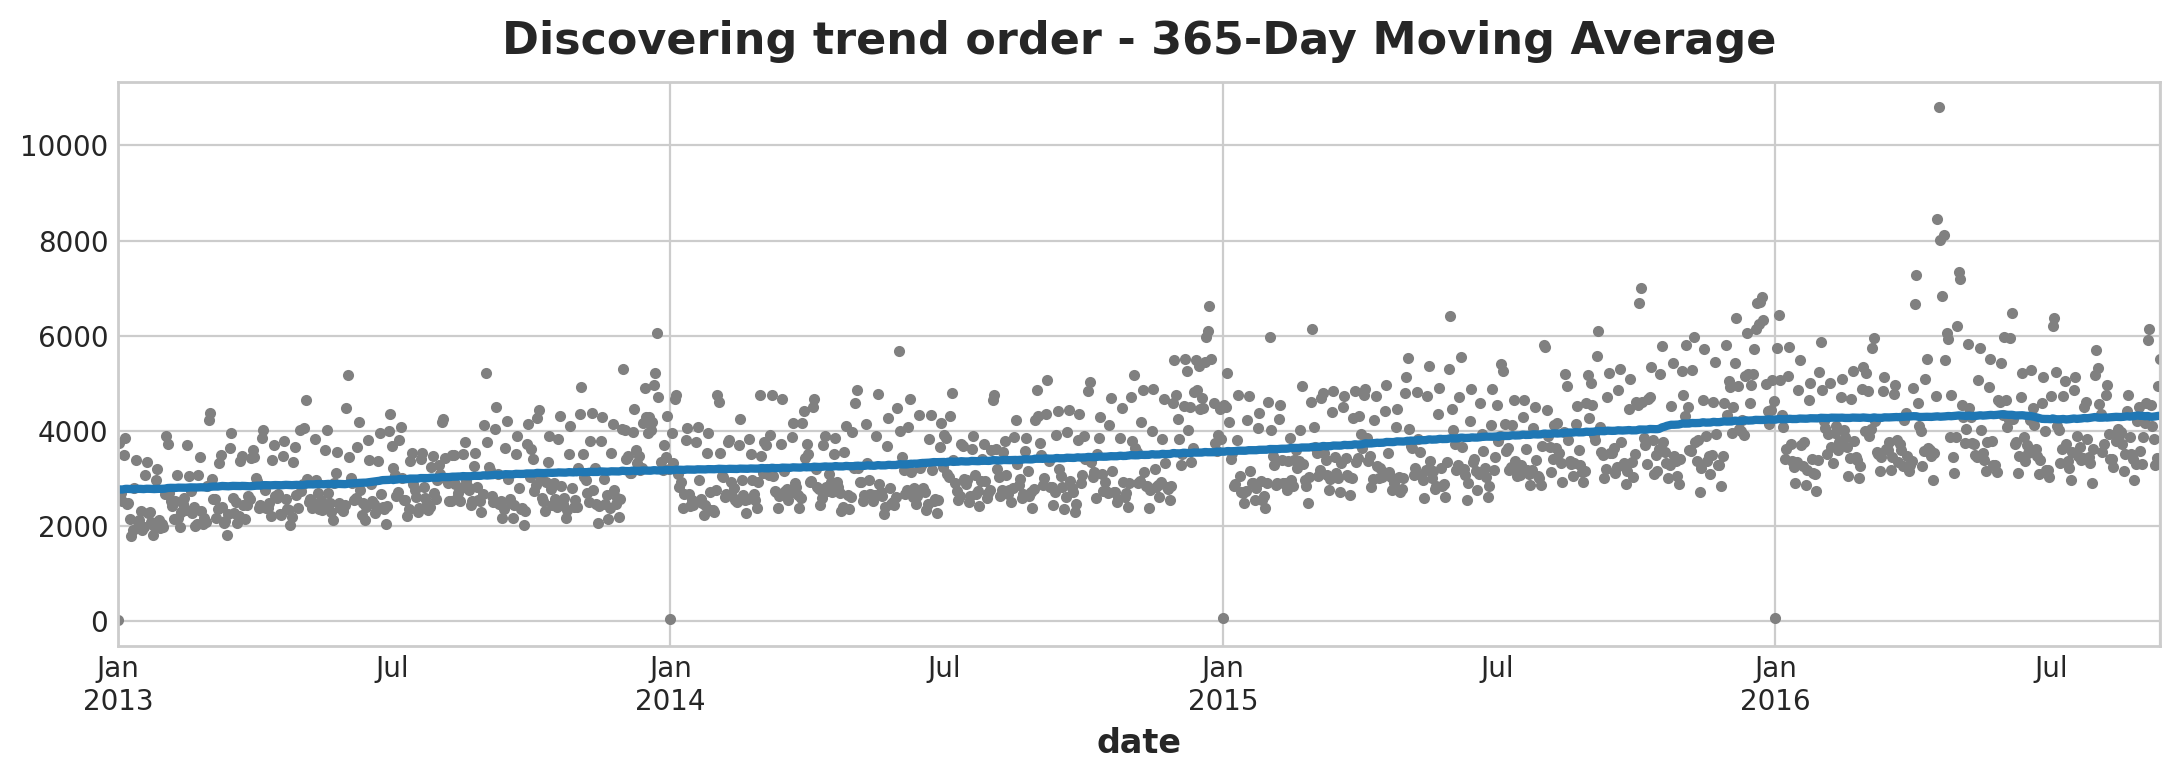

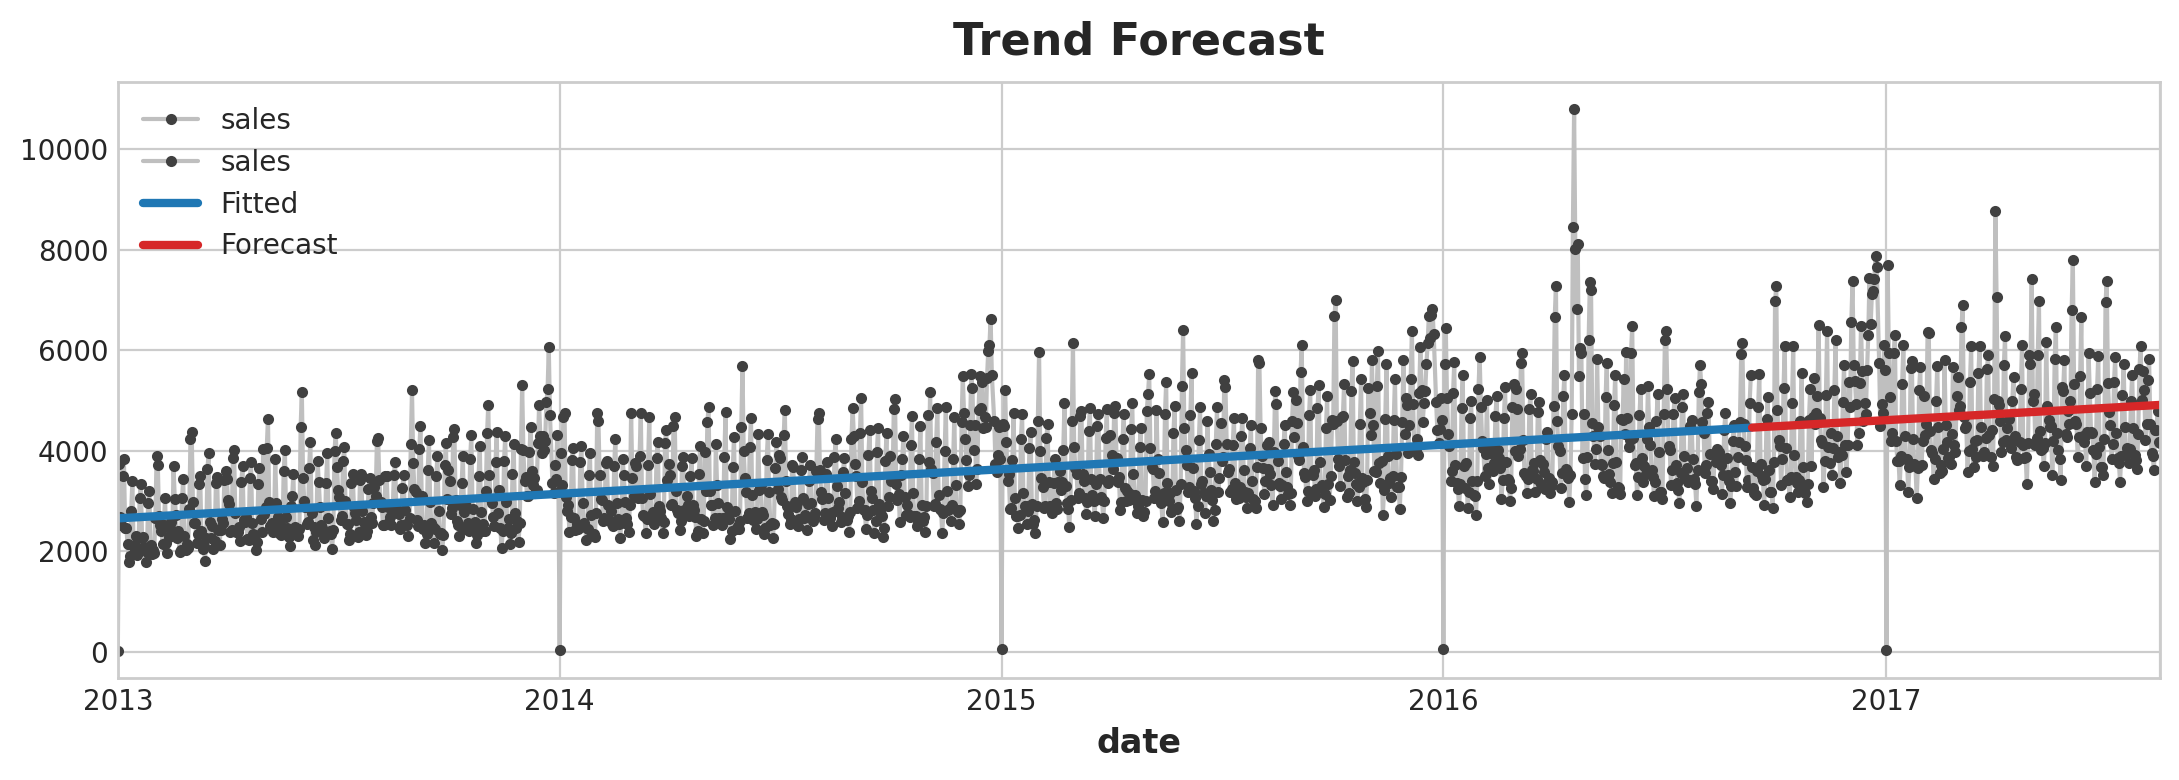

In [10]:
Trend_evaluation(df_train, window=365)
_ = Trend_train(df_train, df_vali, model=LinearRegression(), ord=1, show=True)

/tmp/ipykernel_20/2294217787.py:31: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', False)` for the same effect.

  ax = sns.lineplot(
/tmp/ipykernel_20/2294217787.py:31: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', False)` for the same effect.

  ax = sns.lineplot(
/tmp/ipykernel_20/2294217787.py:59: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version.
  fs = pd.Timedelta("1Y") / pd.Timedelta("1D")


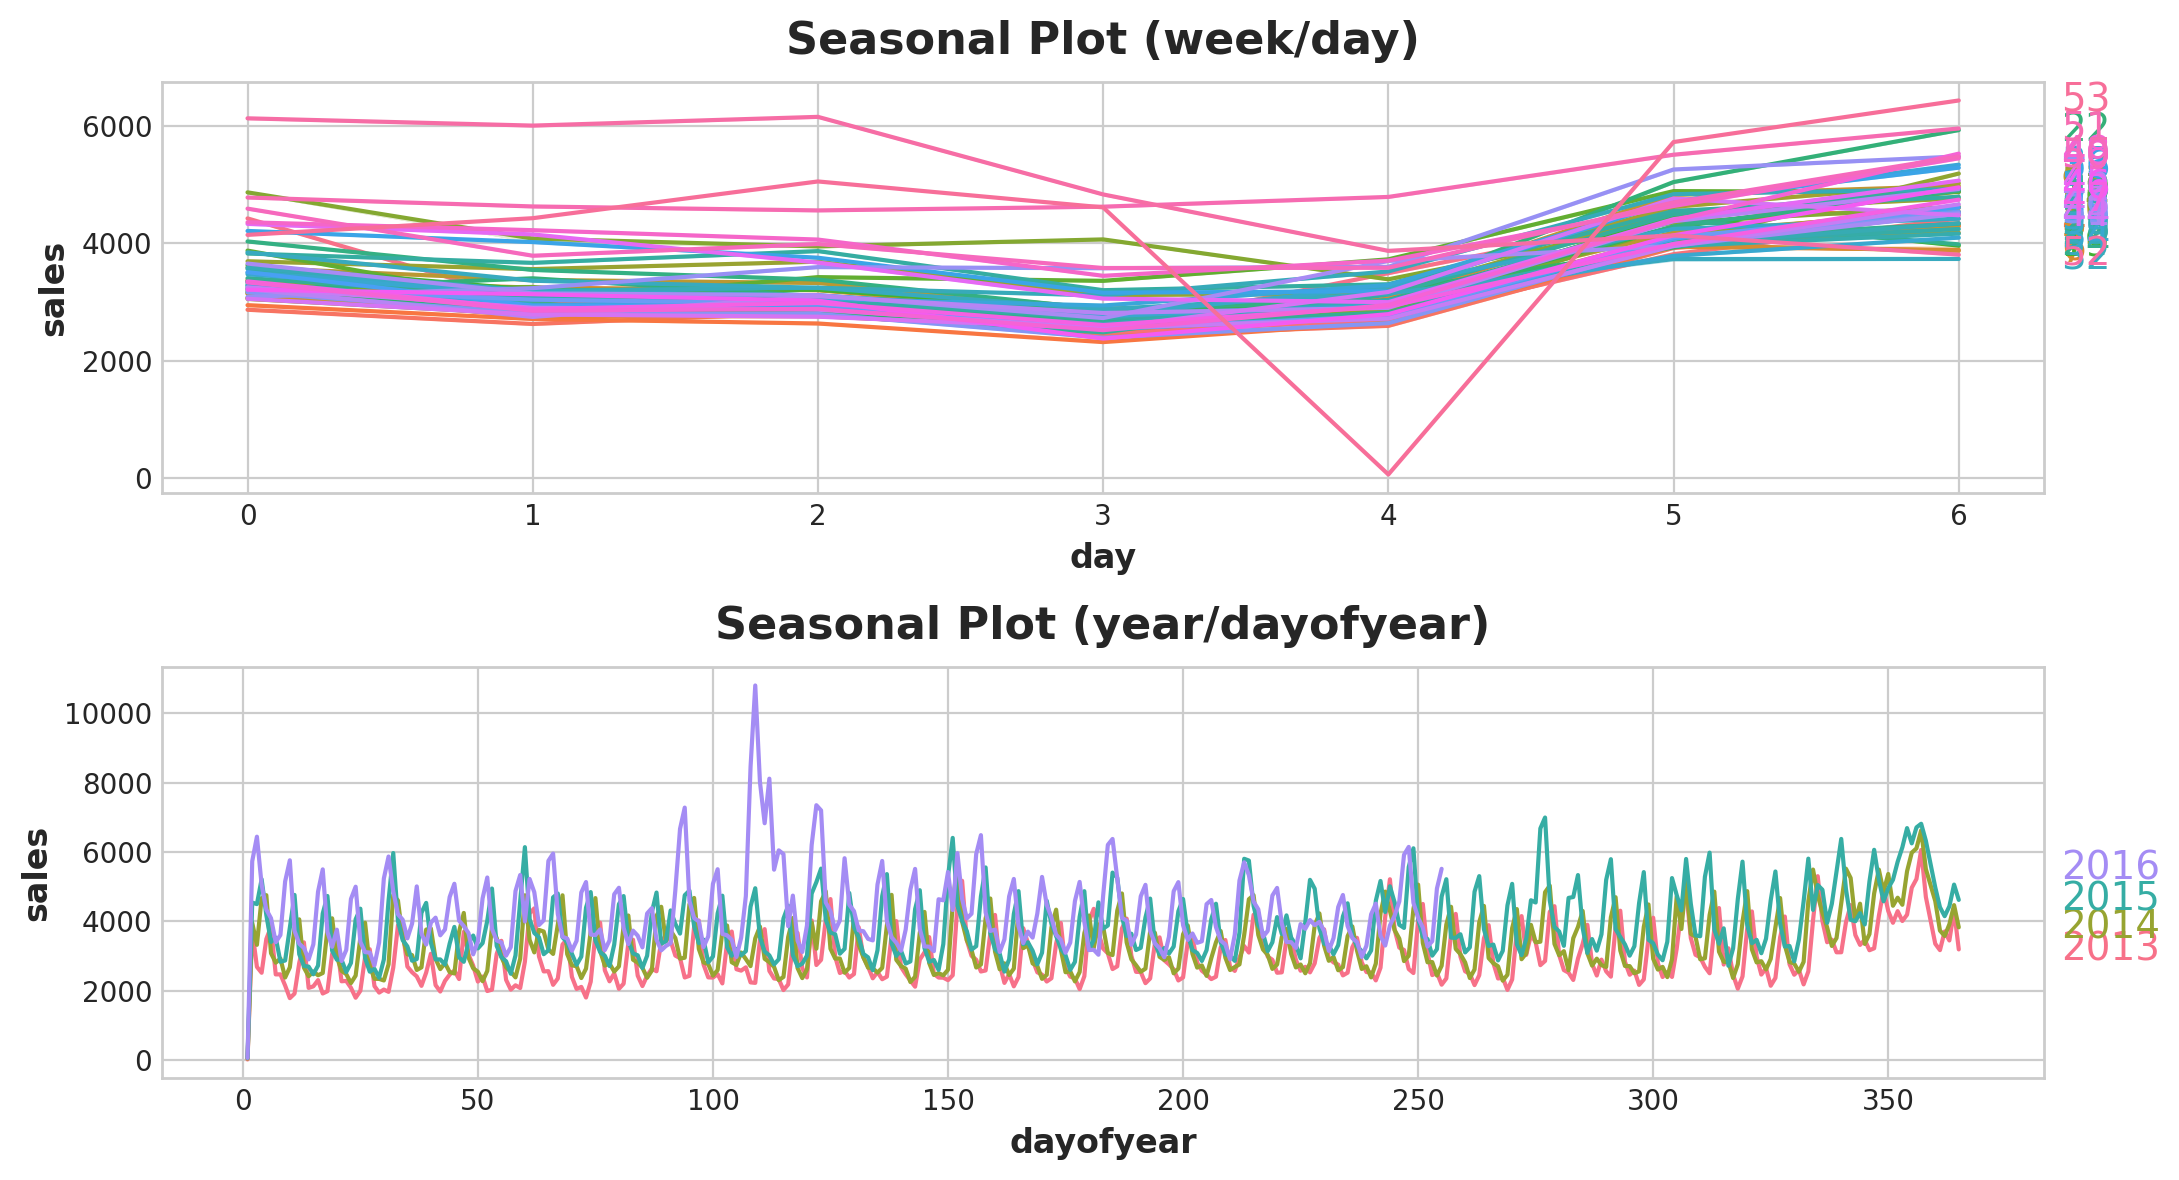

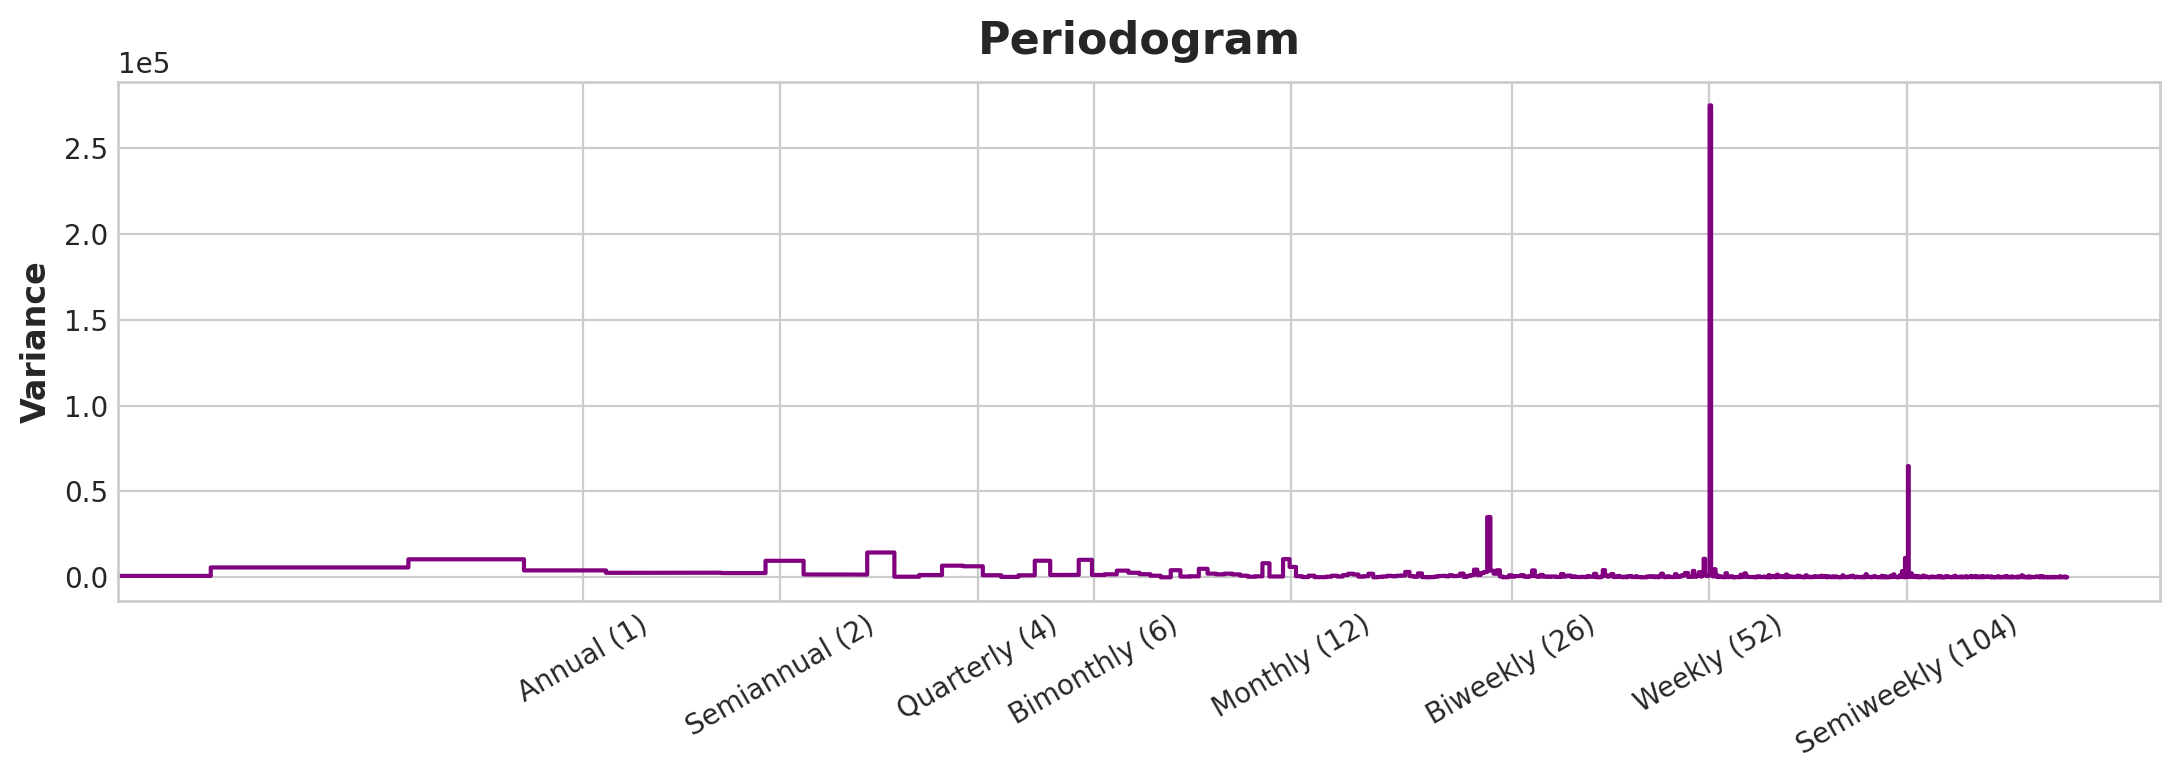

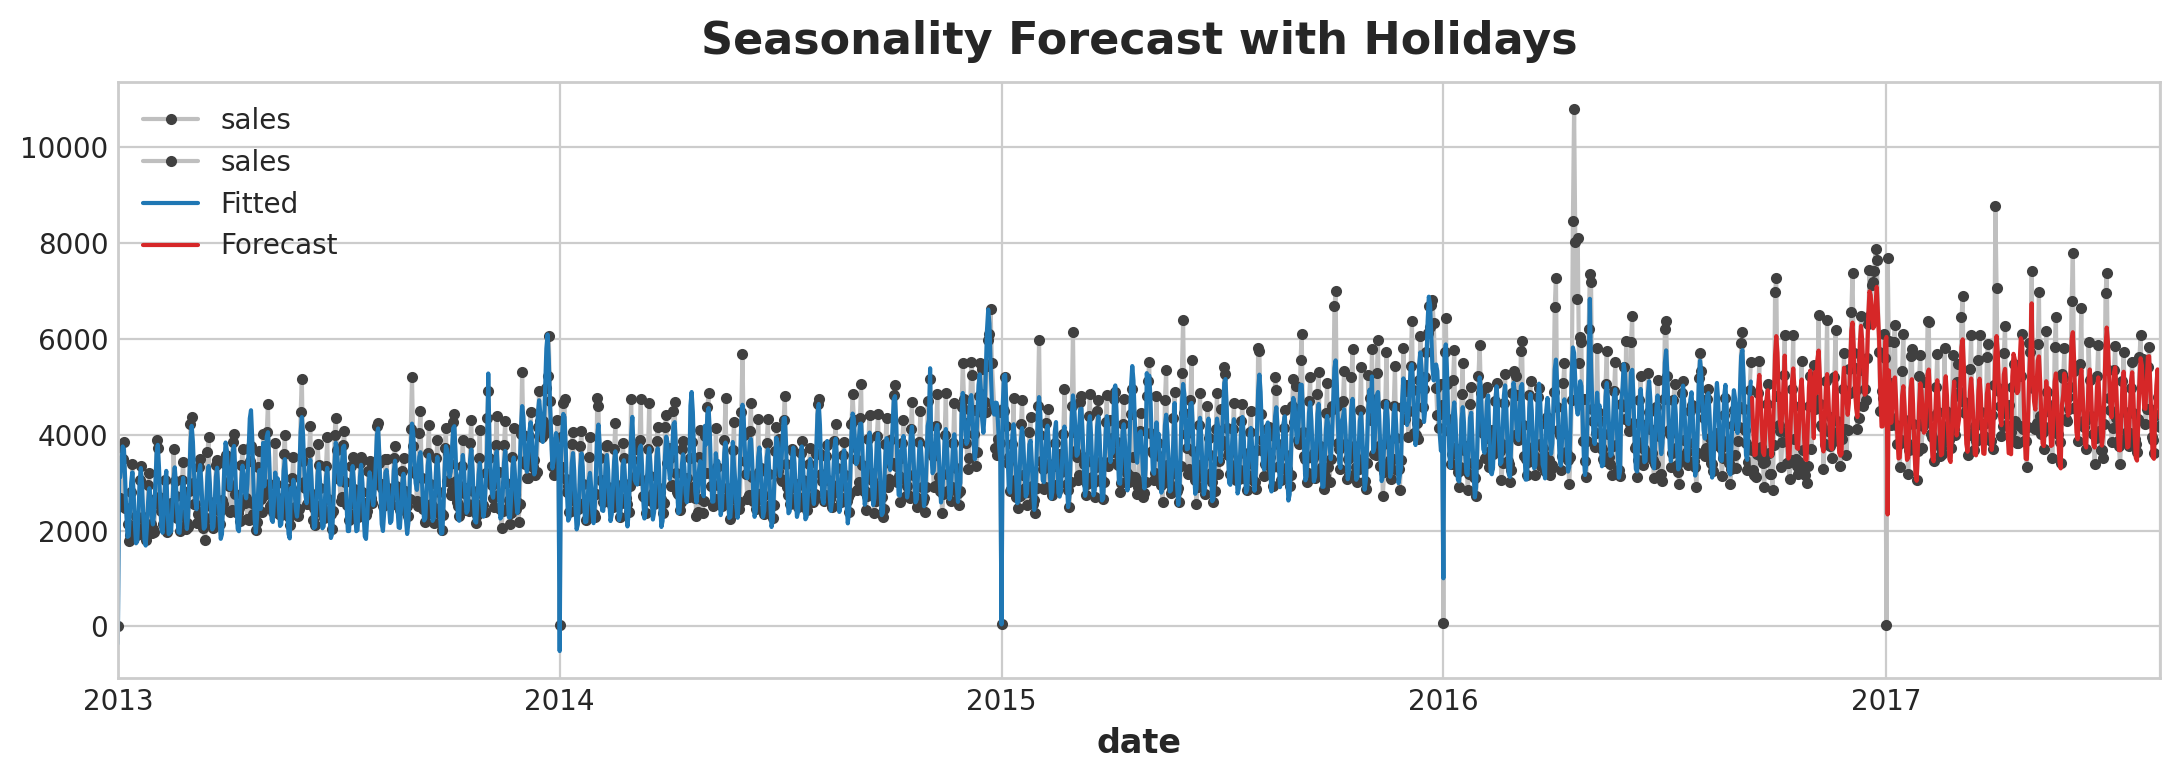

/tmp/ipykernel_20/2294217787.py:59: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version.
  fs = pd.Timedelta("1Y") / pd.Timedelta("1D")


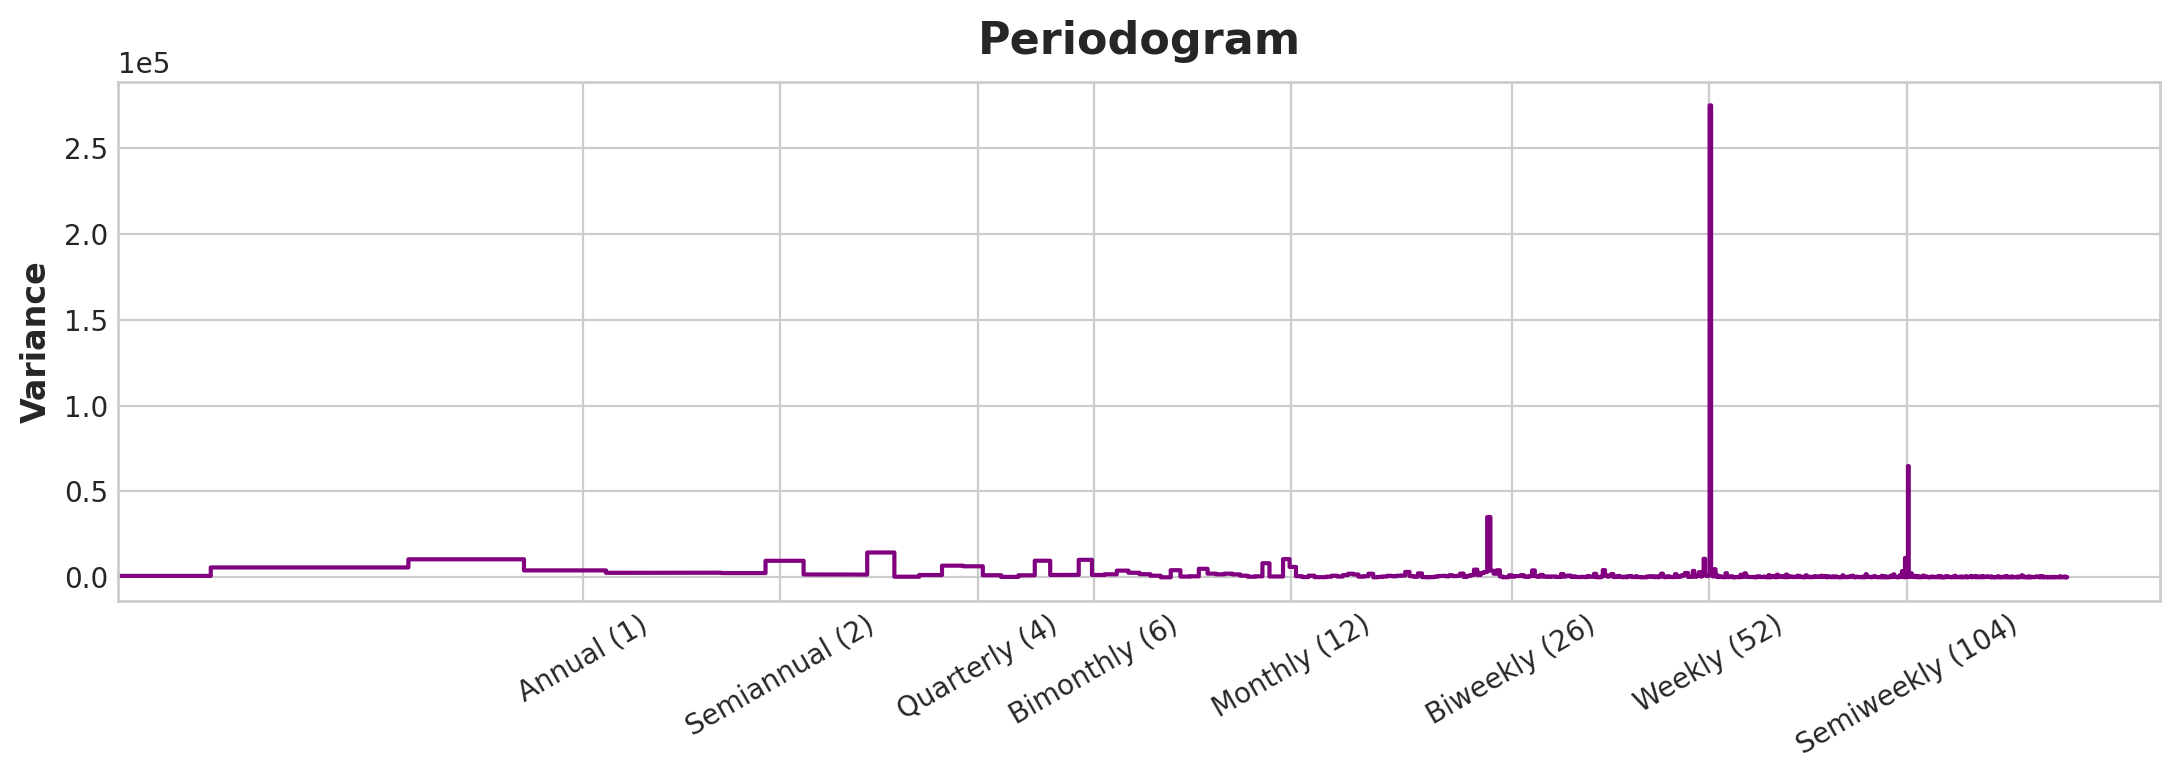

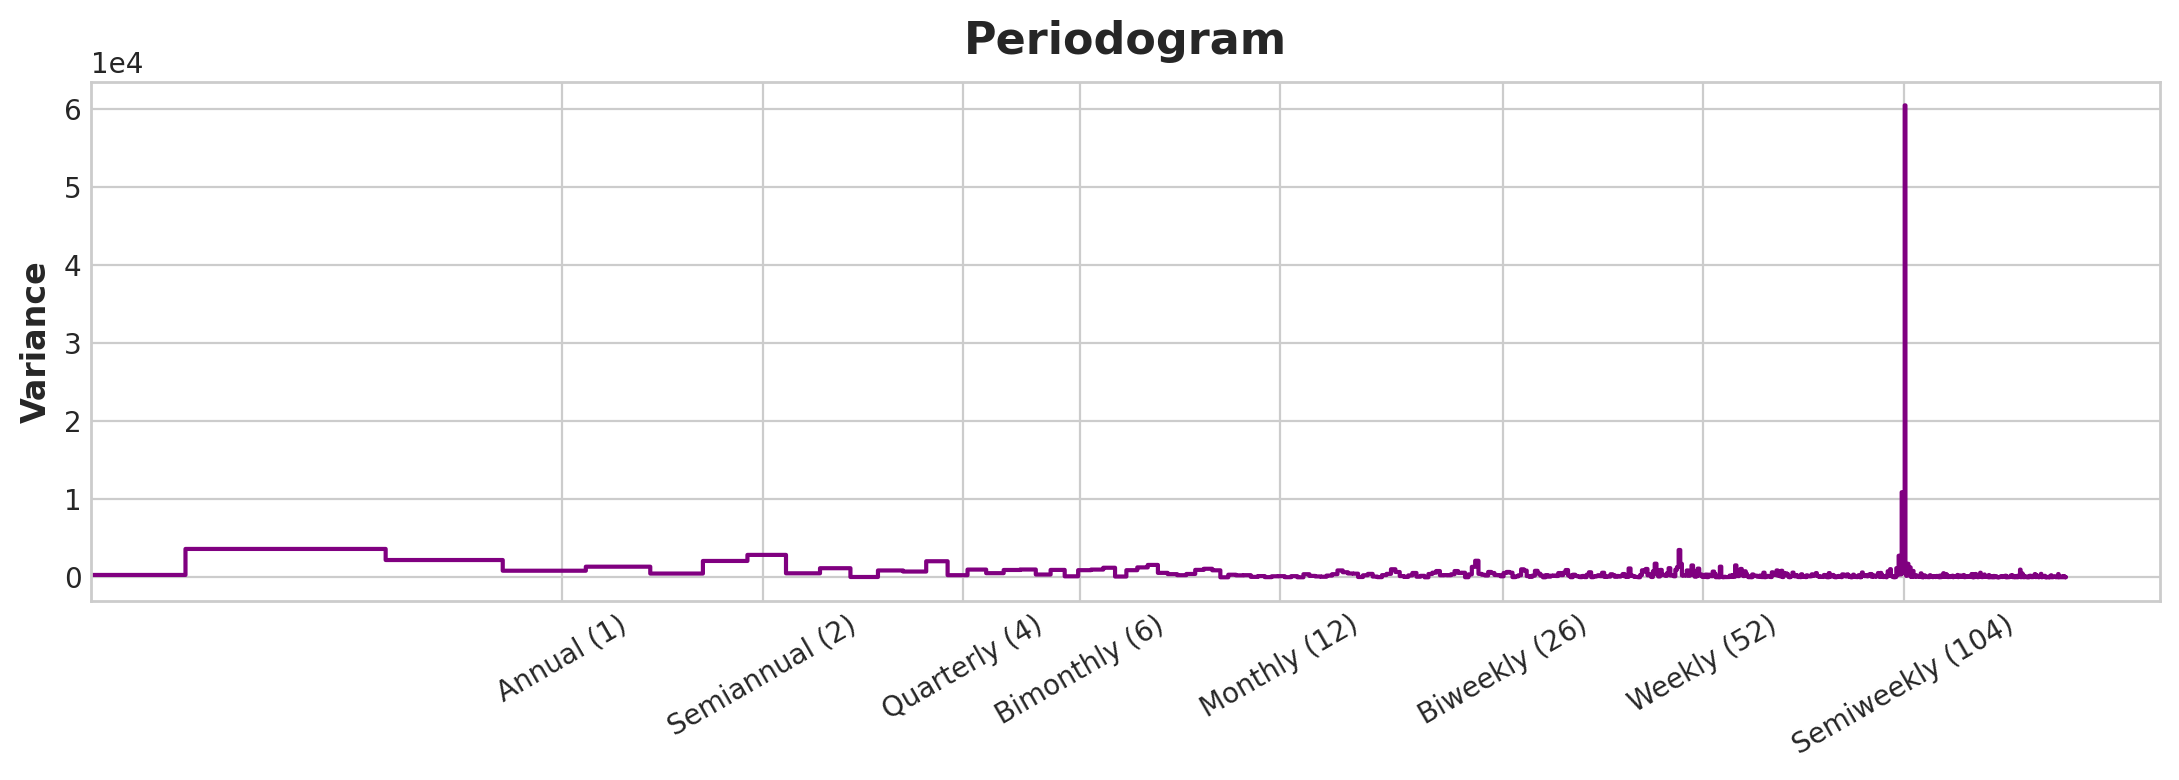

First Train
Training RMSLE: 0.19514
Validation RMSLE: 0.31053


In [11]:
Indicators_evaluation(df_train)
y_pred_seas, y_fore_seas = Seasonality_train_holi(df_train, df_vali, ord=1, wee=True, A_ord=40, M_ord=1, W_ord=1)
Seasonality_efficiency(df_train, y_pred_seas)

#y_pred_seas2, y_fore_seas2 = Seasonality_train_holi(df_train, df_vali, ord=1, wee=True, A_ord=0, M_ord=0, W_ord=0, show=False)
#plot_periodogram(df_train['sales'] - y_pred_seas2)

print("\033[31m" + 'First Train' + "\033[0m")
Erronizando(df_train['sales'], df_vali['sales'], y_pred_seas, y_fore_seas)
#print("\033[31m" + '\nSecond Train' + "\033[0m")
#Erronizando(df_train['sales'], df_vali['sales'], y_pred_seas2, y_fore_seas2)

## *Ruído Branco*

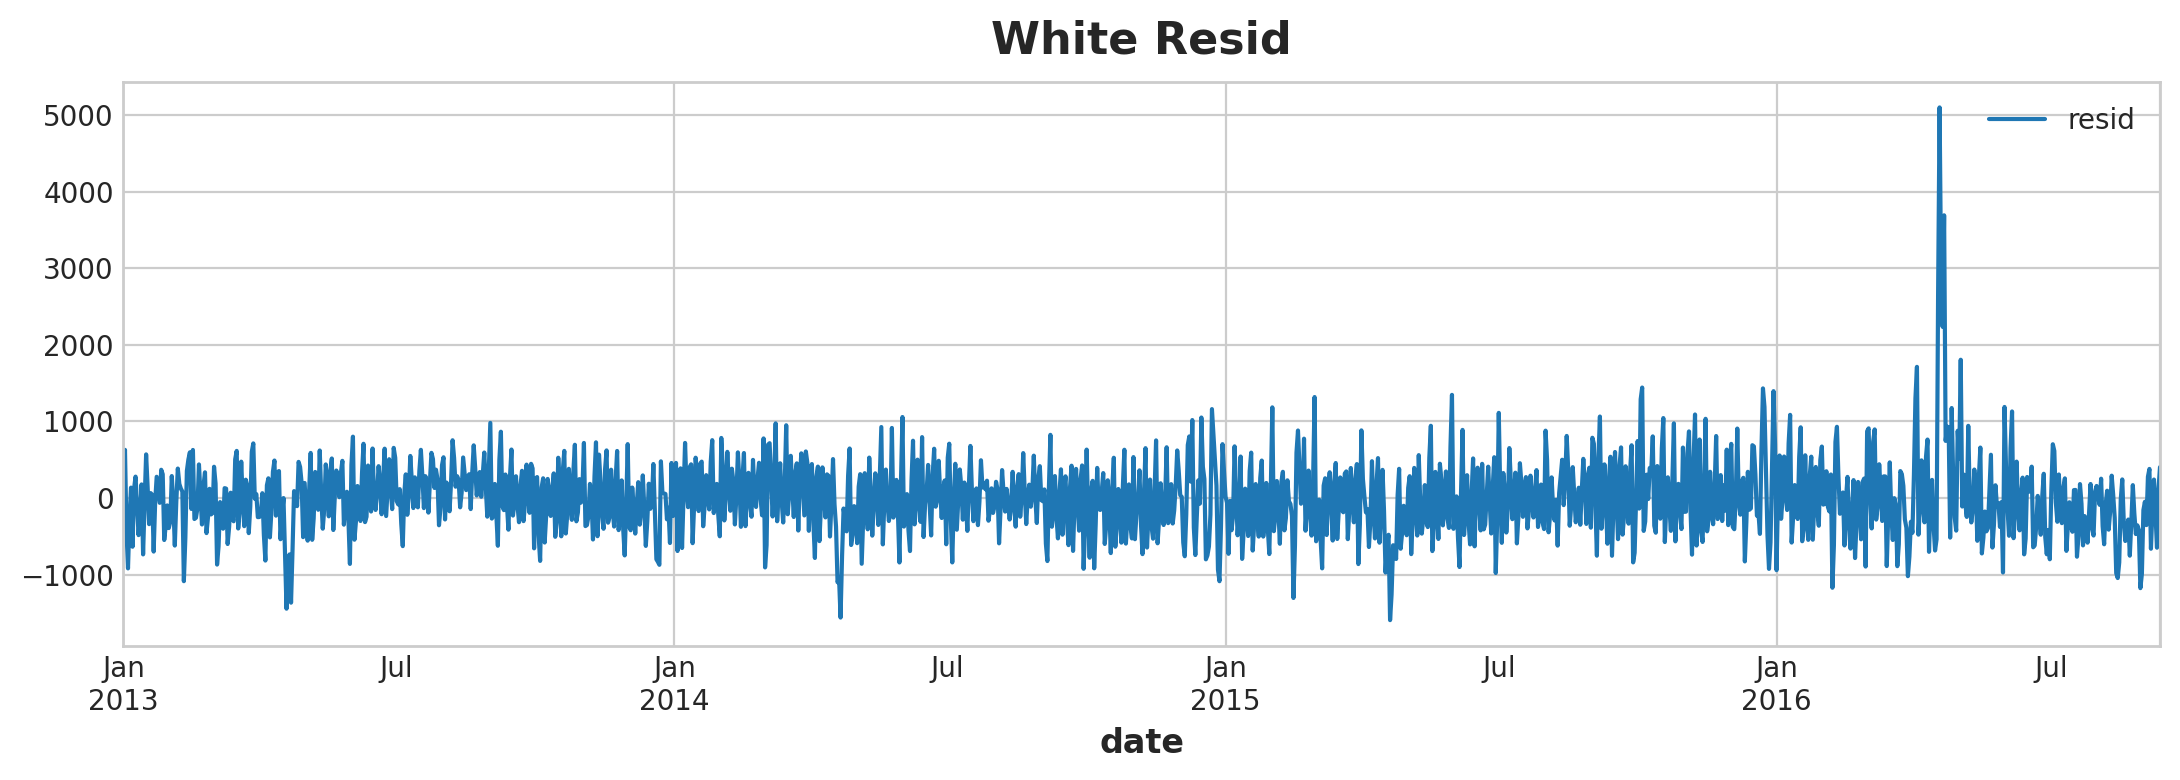

In [12]:
ax = (df_train["sales"] - y_pred_seas).plot(title="White Resid", label="resid", color='C0')
ax.legend()
plt.show()

## *Walking validation*

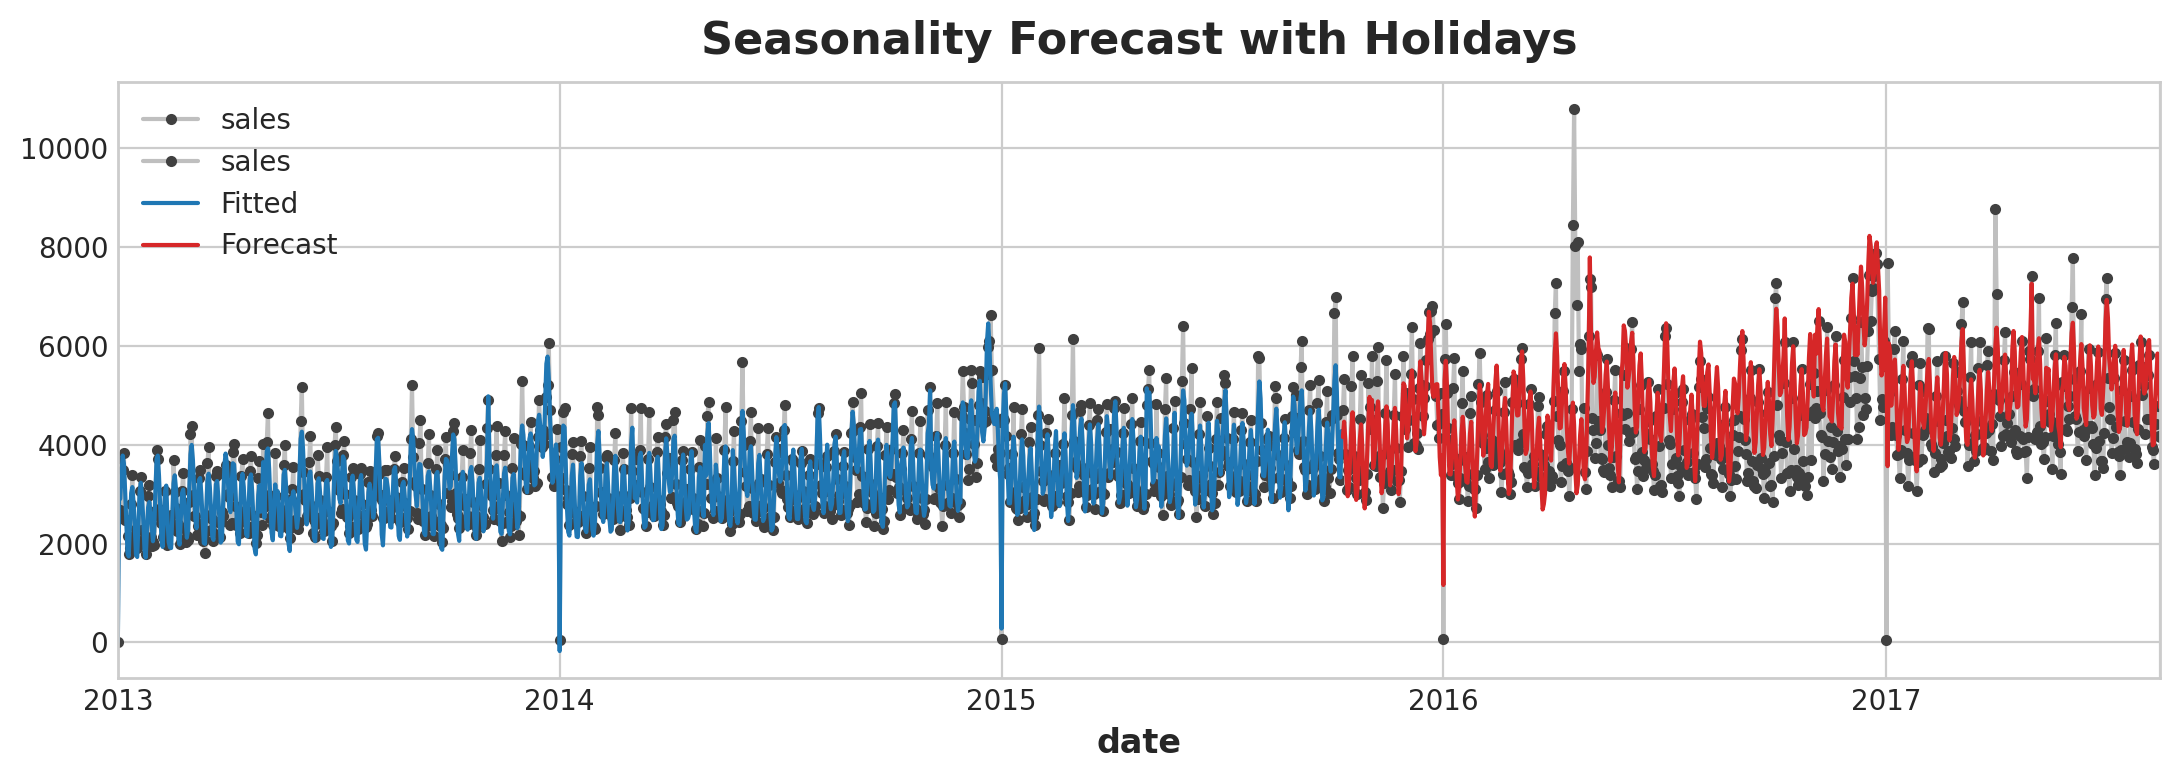

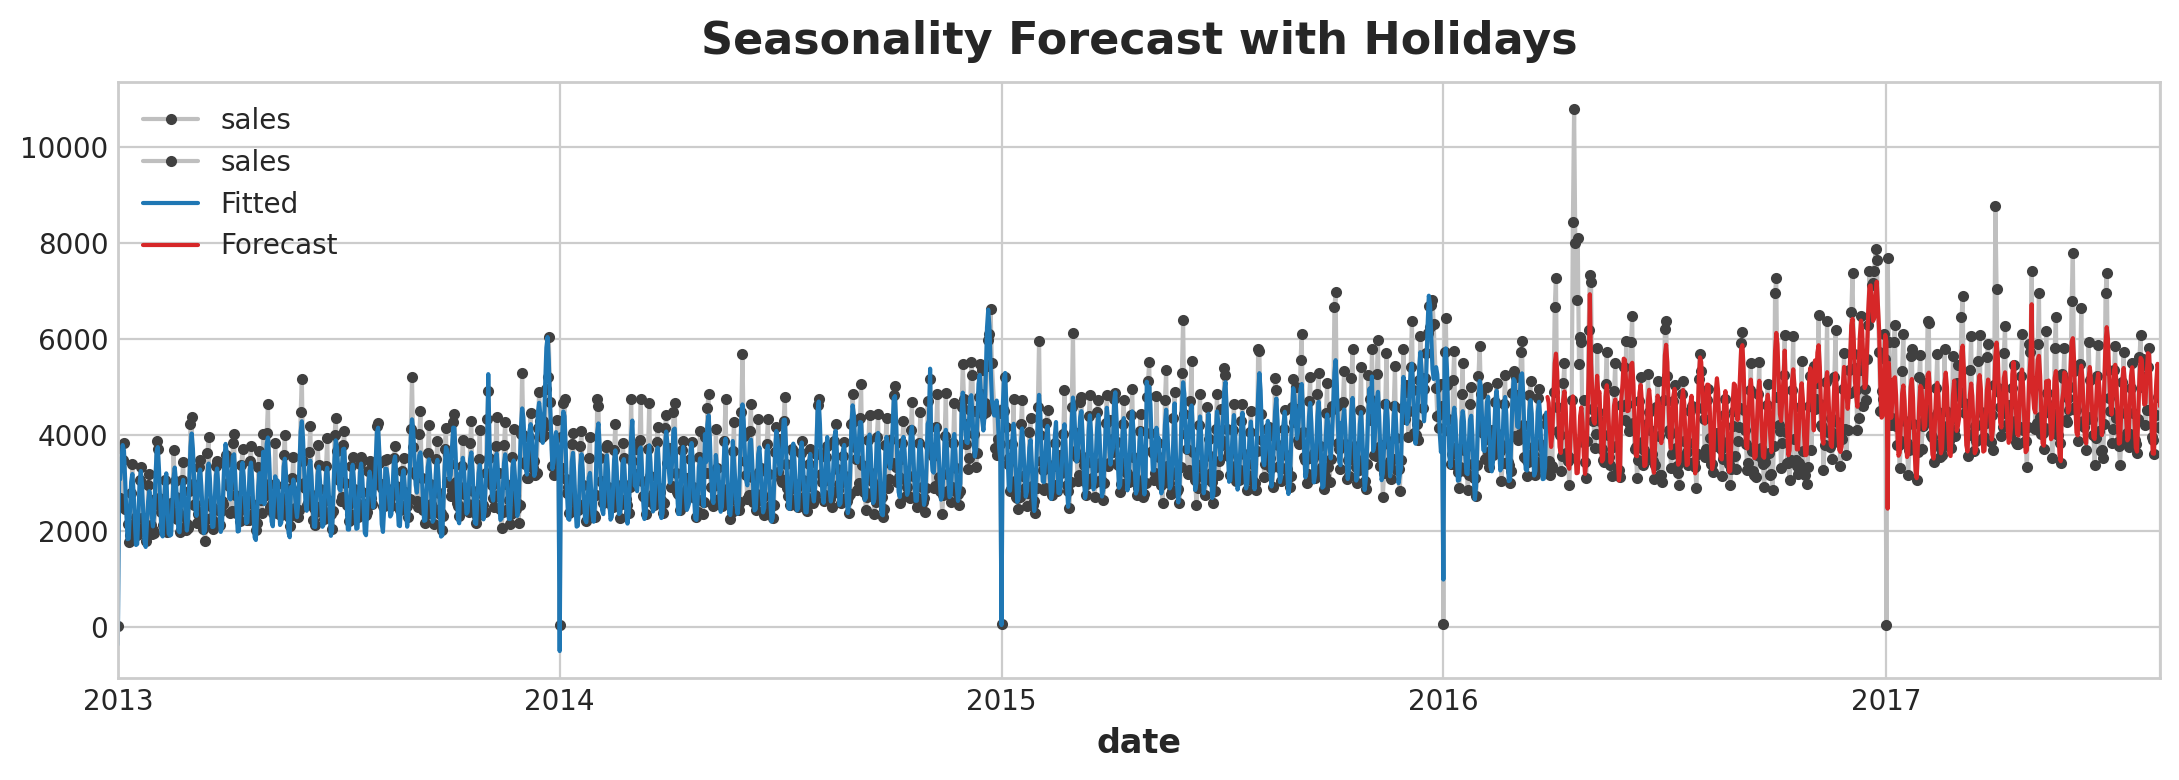

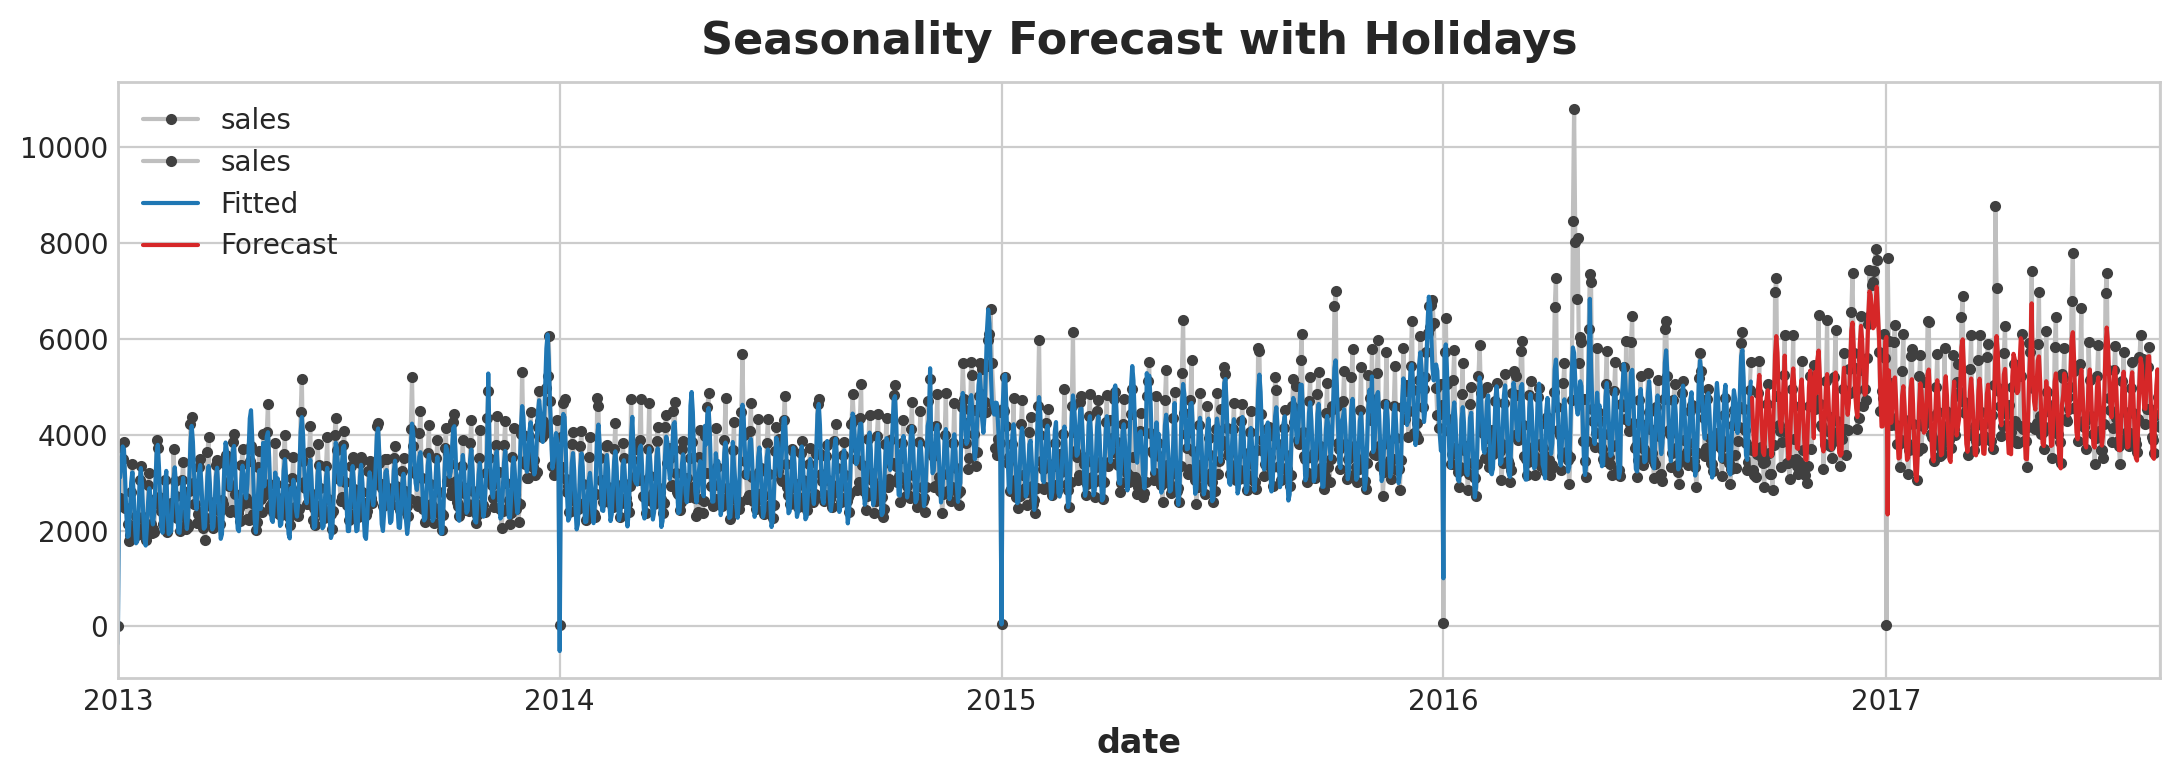


40% of validation
Training RMSLE: 0.17385
Validation RMSLE: 0.29582

30% of validation
Training RMSLE: 0.19667
Validation RMSLE: 0.27667

20% of validation
Training RMSLE: 0.19514
Validation RMSLE: 0.31053


In [13]:
df_train40, df_vali40 = train_test_split(df, test_size=0.4, shuffle=False)
df_train30, df_vali30 = train_test_split(df, test_size=0.3, shuffle=False)
df_train20, df_vali20 = train_test_split(df, test_size=0.2, shuffle=False)

y_pred_seas40, y_fore_seas40 = Seasonality_train_holi(df_train40, df_vali40, ord=1, wee=True, A_ord=40, M_ord=1, W_ord=1)
y_pred_seas30, y_fore_seas30 = Seasonality_train_holi(df_train30, df_vali30, ord=1, wee=True, A_ord=40, M_ord=1, W_ord=1)
y_pred_seas20, y_fore_seas20 = Seasonality_train_holi(df_train20, df_vali20, ord=1, wee=True, A_ord=40, M_ord=1, W_ord=1)

print("\033[31m" + '\n40% of validation' + "\033[0m")
Erronizando(df_train40['sales'], df_vali40['sales'], y_pred_seas40, y_fore_seas40)
print("\033[31m" + '\n30% of validation' + "\033[0m")
Erronizando(df_train30['sales'], df_vali30['sales'], y_pred_seas30, y_fore_seas30)
print("\033[31m" + '\n20% of validation' + "\033[0m")
Erronizando(df_train20['sales'], df_vali20['sales'], y_pred_seas20, y_fore_seas20)

## *Segundo treino em cada loja*

In [14]:
for lol in range(54):

    X_train = pd.DataFrame()
    X_train['p-sales'] = y_pred_seas
    X_vali = pd.DataFrame()
    X_vali['p-sales'] = y_fore_seas

    a = train[train['family'] == familia_t]
    a = a[a['store_nbr'] == str(lol+1)]
    y_train, y_vali = train_test_split(a['sales'], test_size=0.2, shuffle=False)

    fer_train, fer_vali = Holidayzando(df_train, df_vali, national=False, reg_loc=True, sto_nbr=stores.iloc[lol][0])
    X_feriados_train = pd.get_dummies(fer_train)
    X_feriados_vali = pd.get_dummies(fer_vali)

    X_train = X_train.join(X_feriados_train, on='date').fillna(0.0)
    X_vali = X_vali.join(X_feriados_train, on='date').fillna(0.0)
    for i in range(len(X_feriados_vali.index)):
        for j in X_feriados_vali.columns.tolist():
            if X_feriados_vali.iloc[i][j] == 1:
                X_vali.loc[X_feriados_vali.index[i]][j] = 1

    X_vali['cluster'] = stores.iloc[lol][4]
    X_train['cluster'] = stores.iloc[lol][4]

    xgb = XGBRegressor()
    xgb.fit(X_train, y_train)
    y_pred_boosted = xgb.predict(X_train)
    y_pred_boosted = pd.DataFrame(y_pred_boosted, index=X_train.index)
    y_fore_boosted = xgb.predict(X_vali)
    y_fore_boosted = pd.DataFrame(y_fore_boosted, index=X_vali.index)

    if lol > 0:
        y_pred_seas_all = pd.concat([y_pred_seas_all, y_pred_seas])
        y_fore_seas_all = pd.concat([y_fore_seas_all, y_fore_seas])
        y_pred_boosted_all = pd.concat([y_pred_boosted_all, y_pred_boosted])
        y_fore_boosted_all = pd.concat([y_fore_boosted_all, y_fore_boosted])
        y_train_all = pd.concat([y_train_all, y_train])
        y_vali_all = pd.concat([y_vali_all, y_vali])
    else:
        y_pred_seas_all = y_pred_seas
        y_fore_seas_all = y_fore_seas
        y_pred_boosted_all = y_pred_boosted
        y_fore_boosted_all = y_fore_boosted
        y_train_all = y_train
        y_vali_all = y_vali

print("\033[31m" + 'Não treinando novamente' + "\033[0m")
Erronizando(y_train_all, y_vali_all, y_pred_seas_all, y_fore_seas_all)

print("\033[31m" + '\nTreinando novamente' + "\033[0m")
Erronizando(y_train_all, y_vali_all, y_pred_boosted_all, y_fore_boosted_all)

Não treinando novamente
Training RMSLE: 2.51693
Validation RMSLE: 1.37174

Treinando novamente
Training RMSLE: 1.49324
Validation RMSLE: 1.18968


# **Treinamento para Submeter**

In [15]:
# parâmetros obtidos através de testes sobre as execuções acima em busca dos melhores parâmetros
data = {'family': test['family'].head(33).to_list(),
        'ord': [2, 0, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 3, 1, 2, 1, 1, 2, 1, 1, 1, 1],
        'wee': [True, True, True, True, False, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, False, True],
        'A_ord': [10, 0, 30, 10, 0, 1, 0, 10, 40, 0, 40, 40, 40, 5, 0, 5, 0, 40, 30, 0, 5, 5, 0, 0, 0, 40, 10, 2, 10, 10, 10, 0, 10],
        'M_ord': [1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        'W_ord': [1, 0, 3, 3, 0, 1, 2, 2, 4, 1, 2, 0, 1, 1, 1, 2, 2, 2, 1, 2, 1, 2, 2, 3, 0, 1, 2, 2, 2, 1, 1, 0, 1],
        'corte': [' ', '2015-06', ' ', ' ', '2016-10-12', ' ', '2015-07', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', '2014-09', '2014-09', ' ', '2015-05-05', '2015-06', ' ', ' ', ' ', '2015-04', ' ', ' ', '2015-06', '2015-06', ' ', ' ', '2015-06', '2013-12', ' ']
       }

parameters = pd.DataFrame(data)

In [16]:
sbf_tr = train.groupby(['family', 'date']).sales.mean().unstack('family')
obf_tr = train.groupby(['family', 'date']).onpromotion.mean().unstack('family')
obf_te = test.groupby(['family', 'date']).onpromotion.mean().unstack('family')
prev = pd.DataFrame()
fore = pd.DataFrame()

for i in range(len(parameters.index)):
    row = parameters.iloc[i]
    
    df_tr = pd.DataFrame()
    df_tr['sales'] = sbf_tr[row[0]]
    df_tr['onpromotion'] = obf_tr[row[0]]
    new_oil = oil.reindex(df_tr.index)
    new_oil = new_oil.fillna(method='bfill')
    df_tr['dcoilwtico'] = new_oil['dcoilwtico']
    if row[6] != ' ':
        df_tr = df_tr[row[6]:]

    df_te = pd.DataFrame()
    df_te['onpromotion'] = obf_te[row[0]]
    new_oil = oil.reindex(df_te.index)
    new_oil = new_oil.fillna(method='bfill')
    df_te['dcoilwtico'] = new_oil['dcoilwtico']  
    
    prev[row[0]], fore[row[0]] = Seasonality_train_holi(df_tr, df_te, ord=row[1], wee=row[2], A_ord=row[3], M_ord=row[4], W_ord=row[5], show=False)

In [17]:
def definitive_family_forecast(y_pred, y_fore, fam):
    sales_by_store = pd.DataFrame()
    
    for lol in range(54):
        X_train = pd.DataFrame()
        X_train['p-sales'] = y_pred
        X_fore = pd.DataFrame()
        X_fore['p-sales'] = y_fore

        a = train[train['family'] == fam]
        y_train = a[a['store_nbr'] == str(lol+1)]
        y_train = y_train['sales'].reindex(y_pred.index)

        fer_train, fer_vali = Holidayzando(y_pred, y_fore, national=False, reg_loc=True, sto_nbr=stores.iloc[lol][0])
        X_feriados_train = pd.get_dummies(fer_train)
        X_feriados_vali = pd.get_dummies(fer_vali)

        X_train = X_train.join(X_feriados_train, on='date').fillna(0.0)
        X_fore = X_fore.join(X_feriados_train, on='date').fillna(0.0)
        for i in range(len(X_feriados_vali.index)):
            for j in X_feriados_vali.columns.tolist():
                if X_feriados_vali.iloc[i][j] == 1:
                    X_fore.loc[X_feriados_vali.index[i]][j] = 1

        X_fore['cluster'] = stores.iloc[lol][4]
        X_train['cluster'] = stores.iloc[lol][4]

        xgb = XGBRegressor()
        xgb.fit(X_train, y_train)
        y_fore_boosted = xgb.predict(X_fore)
        y_fore_boosted = pd.DataFrame(y_fore_boosted, index=X_fore.index)

        sales_by_store[str(lol+1)] = y_fore_boosted
    
    return sales_by_store

In [18]:
A = pd.DataFrame(); B = pd.DataFrame(); C = pd.DataFrame(); D = pd.DataFrame(); E = pd.DataFrame(); 
F = pd.DataFrame(); G = pd.DataFrame(); H = pd.DataFrame(); I = pd.DataFrame(); J = pd.DataFrame(); 
K = pd.DataFrame(); L = pd.DataFrame(); M = pd.DataFrame(); N = pd.DataFrame(); O = pd.DataFrame(); 
P = pd.DataFrame(); Q = pd.DataFrame(); R = pd.DataFrame(); S = pd.DataFrame(); T = pd.DataFrame(); 
U = pd.DataFrame(); V = pd.DataFrame(); W = pd.DataFrame(); X = pd.DataFrame(); Y = pd.DataFrame(); 
Z = pd.DataFrame(); AA = pd.DataFrame(); AB = pd.DataFrame(); AC = pd.DataFrame(); AD = pd.DataFrame(); 
AE = pd.DataFrame(); AF = pd.DataFrame(); AG = pd.DataFrame(); 

all_families = [A, B, C, D, E, F, G, H, I, J, K, L, M, N, O, P, Q, R, S, T, U, V, W, X, Y, Z, AA, AB, AC, AD, AE, AF, AG]

for i in range(len(all_families)):
    fam = prev.columns[i]
    first_non_nan_index = prev[fam].first_valid_index()
    
    y_fore = fore[fam]    
    y_pred = prev[fam]
    y_pred = y_pred[first_non_nan_index:]
    all_families[i] = definitive_family_forecast(y_pred, y_fore, fam)

In [19]:
for i in range(len(test.index)):
    sto = test.iloc[i][1]
    fam = test.iloc[i][2]
    
    aux = prev.columns.to_list()
    fam = aux.index(fam)
    
    sample.at[i, 'sales'] = all_families[fam][sto][test.index[0]]

In [20]:
sample.to_csv('submission.csv', index=False)